In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                       | 0/60000 [00:00<?, ?it/s]

 13%|███████████▌                                                                             | 7763/60000 [00:00<00:00, 77616.20it/s]

 26%|██████████████████████▊                                                                 | 15573/60000 [00:00<00:00, 77898.95it/s]

 39%|██████████████████████████████████▎                                                     | 23370/60000 [00:00<00:00, 77926.85it/s]

 52%|█████████████████████████████████████████████▋                                          | 31163/60000 [00:00<00:00, 70855.37it/s]

 64%|████████████████████████████████████████████████████████▏                               | 38335/60000 [00:00<00:00, 69878.09it/s]

 76%|██████████████████████████████████████████████████████████████████▌                     | 45424/60000 [00:00<00:00, 70201.39it/s]

 89%|██████████████████████████████████████████████████████████████████████████████          | 53210/60000 [00:00<00:00, 72613.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 72374.11it/s]

  0%|                                                                                                       | 0/10000 [00:00<?, ?it/s]

 77%|████████████████████████████████████████████████████████████████████▏                    | 7666/10000 [00:00<00:00, 76653.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 76353.08it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 umry49p9


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                         | 0/383 [00:00<?, ?it/s]

  0%|▎                                                                                                | 1/383 [00:00<05:00,  1.27it/s]

  1%|█▎                                                                                               | 5/383 [00:00<00:54,  6.99it/s]

  2%|██▎                                                                                              | 9/383 [00:01<00:29, 12.47it/s]

  3%|███▎                                                                                            | 13/383 [00:01<00:21, 17.48it/s]

  4%|████▎                                                                                           | 17/383 [00:01<00:16, 21.78it/s]

  5%|█████▎                                                                                          | 21/383 [00:01<00:14, 25.27it/s]

  7%|██████▎                                                                                         | 25/383 [00:01<00:12, 27.98it/s]

  8%|███████▎                                                                                        | 29/383 [00:01<00:11, 30.04it/s]

  9%|████████▎                                                                                       | 33/383 [00:01<00:11, 31.59it/s]

 10%|█████████▎                                                                                      | 37/383 [00:01<00:10, 32.72it/s]

 11%|██████████▎                                                                                     | 41/383 [00:01<00:10, 33.51it/s]

 12%|███████████▎                                                                                    | 45/383 [00:02<00:09, 34.02it/s]

 13%|████████████▎                                                                                   | 49/383 [00:02<00:09, 34.23it/s]

 14%|█████████████▎                                                                                  | 53/383 [00:02<00:09, 34.60it/s]

 15%|██████████████▎                                                                                 | 57/383 [00:02<00:09, 34.83it/s]

 16%|███████████████▎                                                                                | 61/383 [00:02<00:09, 35.00it/s]

 17%|████████████████▎                                                                               | 65/383 [00:02<00:09, 35.12it/s]

 18%|█████████████████▎                                                                              | 69/383 [00:02<00:08, 35.21it/s]

 19%|██████████████████▎                                                                             | 73/383 [00:02<00:08, 35.26it/s]

 20%|███████████████████▎                                                                            | 77/383 [00:02<00:08, 35.22it/s]

 21%|████████████████████▎                                                                           | 81/383 [00:03<00:08, 35.27it/s]

 22%|█████████████████████▎                                                                          | 85/383 [00:03<00:08, 35.28it/s]

 23%|██████████████████████▎                                                                         | 89/383 [00:03<00:08, 35.28it/s]

 24%|███████████████████████▎                                                                        | 93/383 [00:03<00:08, 35.10it/s]

 25%|████████████████████████▎                                                                       | 97/383 [00:03<00:08, 35.15it/s]

 26%|█████████████████████████                                                                      | 101/383 [00:03<00:08, 35.18it/s]

 27%|██████████████████████████                                                                     | 105/383 [00:03<00:07, 35.18it/s]

 28%|███████████████████████████                                                                    | 109/383 [00:03<00:07, 35.13it/s]

 30%|████████████████████████████                                                                   | 113/383 [00:03<00:07, 35.12it/s]

 31%|█████████████████████████████                                                                  | 117/383 [00:04<00:07, 35.12it/s]

 32%|██████████████████████████████                                                                 | 121/383 [00:04<00:07, 35.09it/s]

 33%|███████████████████████████████                                                                | 125/383 [00:04<00:07, 35.09it/s]

 34%|███████████████████████████████▉                                                               | 129/383 [00:04<00:07, 35.16it/s]

 35%|████████████████████████████████▉                                                              | 133/383 [00:04<00:07, 35.15it/s]

 36%|█████████████████████████████████▉                                                             | 137/383 [00:04<00:07, 35.10it/s]

 37%|██████████████████████████████████▉                                                            | 141/383 [00:04<00:06, 35.12it/s]

 38%|███████████████████████████████████▉                                                           | 145/383 [00:04<00:06, 34.96it/s]

 39%|████████████████████████████████████▉                                                          | 149/383 [00:04<00:06, 34.97it/s]

 40%|█████████████████████████████████████▉                                                         | 153/383 [00:05<00:06, 35.01it/s]

 41%|██████████████████████████████████████▉                                                        | 157/383 [00:05<00:06, 34.94it/s]

 42%|███████████████████████████████████████▉                                                       | 161/383 [00:05<00:06, 34.93it/s]

 43%|████████████████████████████████████████▉                                                      | 165/383 [00:05<00:06, 34.94it/s]

 44%|█████████████████████████████████████████▉                                                     | 169/383 [00:05<00:06, 35.00it/s]

 45%|██████████████████████████████████████████▉                                                    | 173/383 [00:05<00:05, 35.03it/s]

 46%|███████████████████████████████████████████▉                                                   | 177/383 [00:05<00:05, 35.01it/s]

 47%|████████████████████████████████████████████▉                                                  | 181/383 [00:05<00:05, 35.00it/s]

 48%|█████████████████████████████████████████████▉                                                 | 185/383 [00:06<00:05, 35.00it/s]

 49%|██████████████████████████████████████████████▉                                                | 189/383 [00:06<00:05, 35.07it/s]

 50%|███████████████████████████████████████████████▊                                               | 193/383 [00:06<00:05, 35.06it/s]

 51%|████████████████████████████████████████████████▊                                              | 197/383 [00:06<00:05, 34.80it/s]

 52%|█████████████████████████████████████████████████▊                                             | 201/383 [00:06<00:05, 34.76it/s]

 54%|██████████████████████████████████████████████████▊                                            | 205/383 [00:06<00:05, 34.85it/s]

 55%|███████████████████████████████████████████████████▊                                           | 209/383 [00:06<00:04, 34.83it/s]

 56%|████████████████████████████████████████████████████▊                                          | 213/383 [00:06<00:04, 34.80it/s]

 57%|█████████████████████████████████████████████████████▊                                         | 217/383 [00:06<00:04, 34.78it/s]

 58%|██████████████████████████████████████████████████████▊                                        | 221/383 [00:07<00:04, 34.75it/s]

 59%|███████████████████████████████████████████████████████▊                                       | 225/383 [00:07<00:04, 34.79it/s]

 60%|████████████████████████████████████████████████████████▊                                      | 229/383 [00:07<00:04, 34.77it/s]

 61%|█████████████████████████████████████████████████████████▊                                     | 233/383 [00:07<00:04, 34.76it/s]

 62%|██████████████████████████████████████████████████████████▊                                    | 237/383 [00:07<00:04, 34.77it/s]

 63%|███████████████████████████████████████████████████████████▊                                   | 241/383 [00:07<00:04, 34.70it/s]

 64%|████████████████████████████████████████████████████████████▊                                  | 245/383 [00:07<00:03, 34.64it/s]

 65%|█████████████████████████████████████████████████████████████▊                                 | 249/383 [00:07<00:03, 34.52it/s]

 66%|██████████████████████████████████████████████████████████████▊                                | 253/383 [00:07<00:03, 34.48it/s]

 67%|███████████████████████████████████████████████████████████████▋                               | 257/383 [00:08<00:03, 34.44it/s]

 68%|████████████████████████████████████████████████████████████████▋                              | 261/383 [00:08<00:03, 34.45it/s]

 69%|█████████████████████████████████████████████████████████████████▋                             | 265/383 [00:08<00:03, 34.53it/s]

 70%|██████████████████████████████████████████████████████████████████▋                            | 269/383 [00:08<00:03, 34.62it/s]

 71%|███████████████████████████████████████████████████████████████████▋                           | 273/383 [00:08<00:03, 34.75it/s]

 72%|████████████████████████████████████████████████████████████████████▋                          | 277/383 [00:08<00:03, 34.80it/s]

 73%|█████████████████████████████████████████████████████████████████████▋                         | 281/383 [00:08<00:02, 34.61it/s]

 74%|██████████████████████████████████████████████████████████████████████▋                        | 285/383 [00:08<00:02, 34.46it/s]

 75%|███████████████████████████████████████████████████████████████████████▋                       | 289/383 [00:09<00:02, 34.26it/s]

 77%|████████████████████████████████████████████████████████████████████████▋                      | 293/383 [00:09<00:02, 34.18it/s]

 78%|█████████████████████████████████████████████████████████████████████████▋                     | 297/383 [00:09<00:02, 34.15it/s]

 79%|██████████████████████████████████████████████████████████████████████████▋                    | 301/383 [00:09<00:02, 34.13it/s]

 80%|███████████████████████████████████████████████████████████████████████████▋                   | 305/383 [00:09<00:02, 34.13it/s]

 81%|████████████████████████████████████████████████████████████████████████████▋                  | 309/383 [00:09<00:02, 34.05it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▋                 | 313/383 [00:09<00:02, 34.04it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▋                | 317/383 [00:09<00:01, 34.02it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▌               | 321/383 [00:09<00:01, 34.04it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▌              | 325/383 [00:10<00:01, 33.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▌             | 329/383 [00:10<00:01, 34.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▌            | 333/383 [00:10<00:01, 34.03it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▌           | 337/383 [00:10<00:01, 34.05it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 341/383 [00:10<00:01, 33.97it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▌         | 345/383 [00:10<00:01, 34.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▌        | 349/383 [00:10<00:00, 34.50it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▌       | 353/383 [00:10<00:00, 34.67it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▌      | 357/383 [00:11<00:00, 34.81it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 361/383 [00:11<00:00, 34.95it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▌    | 365/383 [00:11<00:00, 34.99it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▌   | 369/383 [00:11<00:00, 35.02it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▌  | 373/383 [00:11<00:00, 35.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████▌ | 377/383 [00:11<00:00, 35.12it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▌| 381/383 [00:11<00:00, 35.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 383/383 [00:11<00:00, 32.47it/s]

train - OK


  0%|                                                                                                          | 0/96 [00:00<?, ?it/s]

  1%|█                                                                                                 | 1/96 [00:00<00:10,  9.34it/s]

  5%|█████                                                                                             | 5/96 [00:00<00:03, 24.53it/s]

  9%|█████████▏                                                                                        | 9/96 [00:00<00:02, 29.29it/s]

 14%|█████████████▏                                                                                   | 13/96 [00:00<00:02, 31.49it/s]

 18%|█████████████████▏                                                                               | 17/96 [00:00<00:02, 32.57it/s]

 22%|█████████████████████▏                                                                           | 21/96 [00:00<00:02, 33.37it/s]

 26%|█████████████████████████▎                                                                       | 25/96 [00:00<00:02, 33.88it/s]

 30%|█████████████████████████████▎                                                                   | 29/96 [00:00<00:01, 34.22it/s]

 34%|█████████████████████████████████▎                                                               | 33/96 [00:01<00:01, 34.43it/s]

 39%|█████████████████████████████████████▍                                                           | 37/96 [00:01<00:01, 34.61it/s]

 43%|█████████████████████████████████████████▍                                                       | 41/96 [00:01<00:01, 34.72it/s]

 47%|█████████████████████████████████████████████▍                                                   | 45/96 [00:01<00:01, 34.79it/s]

 51%|█████████████████████████████████████████████████▌                                               | 49/96 [00:01<00:01, 34.84it/s]

 55%|█████████████████████████████████████████████████████▌                                           | 53/96 [00:01<00:01, 34.84it/s]

 59%|█████████████████████████████████████████████████████████▌                                       | 57/96 [00:01<00:01, 34.90it/s]

 64%|█████████████████████████████████████████████████████████████▋                                   | 61/96 [00:01<00:01, 34.92it/s]

 68%|█████████████████████████████████████████████████████████████████▋                               | 65/96 [00:01<00:00, 34.95it/s]

 72%|█████████████████████████████████████████████████████████████████████▋                           | 69/96 [00:02<00:00, 34.67it/s]

 76%|█████████████████████████████████████████████████████████████████████████▊                       | 73/96 [00:02<00:00, 34.72it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 77/96 [00:02<00:00, 34.76it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████▊               | 81/96 [00:02<00:00, 34.78it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 85/96 [00:02<00:00, 34.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 89/96 [00:02<00:00, 34.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████▉   | 93/96 [00:02<00:00, 35.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 33.22it/s]

val - OK


  0%|                                                                                                          | 0/81 [00:00<?, ?it/s]

  1%|█▏                                                                                                | 1/81 [00:00<00:08,  9.18it/s]

  6%|██████                                                                                            | 5/81 [00:00<00:03, 24.29it/s]

 11%|██████████▉                                                                                       | 9/81 [00:00<00:02, 29.01it/s]

 16%|███████████████▌                                                                                 | 13/81 [00:00<00:02, 31.17it/s]

 21%|████████████████████▎                                                                            | 17/81 [00:00<00:01, 32.40it/s]

 26%|█████████████████████████▏                                                                       | 21/81 [00:00<00:01, 32.97it/s]

 31%|█████████████████████████████▉                                                                   | 25/81 [00:00<00:01, 33.34it/s]

 36%|██████████████████████████████████▋                                                              | 29/81 [00:00<00:01, 33.55it/s]

 41%|███████████████████████████████████████▌                                                         | 33/81 [00:01<00:01, 33.79it/s]

 46%|████████████████████████████████████████████▎                                                    | 37/81 [00:01<00:01, 33.84it/s]

 51%|█████████████████████████████████████████████████                                                | 41/81 [00:01<00:01, 33.85it/s]

 56%|█████████████████████████████████████████████████████▉                                           | 45/81 [00:01<00:01, 34.03it/s]

 60%|██████████████████████████████████████████████████████████▋                                      | 49/81 [00:01<00:00, 34.21it/s]

 65%|███████████████████████████████████████████████████████████████▍                                 | 53/81 [00:01<00:00, 34.31it/s]

 70%|████████████████████████████████████████████████████████████████████▎                            | 57/81 [00:01<00:00, 34.40it/s]

 75%|█████████████████████████████████████████████████████████████████████████                        | 61/81 [00:01<00:00, 34.44it/s]

 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 65/81 [00:01<00:00, 34.49it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████▋              | 69/81 [00:02<00:00, 34.45it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 73/81 [00:02<00:00, 34.41it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████▏    | 77/81 [00:02<00:00, 34.42it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 31.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 32.40it/s]

test InD - OK


  0%|                                                                                                         | 0/536 [00:00<?, ?it/s]

  0%|▏                                                                                                | 1/536 [00:00<01:06,  8.05it/s]

  1%|▉                                                                                                | 5/536 [00:00<00:23, 22.47it/s]

  2%|█▋                                                                                               | 9/536 [00:00<00:19, 27.46it/s]

  2%|██▎                                                                                             | 13/536 [00:00<00:17, 30.02it/s]

  3%|███                                                                                             | 17/536 [00:00<00:16, 31.46it/s]

  4%|███▊                                                                                            | 21/536 [00:00<00:15, 32.36it/s]

  5%|████▍                                                                                           | 25/536 [00:00<00:15, 32.86it/s]

  5%|█████▏                                                                                          | 29/536 [00:00<00:15, 33.23it/s]

  6%|█████▉                                                                                          | 33/536 [00:01<00:15, 33.41it/s]

  7%|██████▋                                                                                         | 37/536 [00:01<00:14, 33.38it/s]

  8%|███████▎                                                                                        | 41/536 [00:01<00:14, 33.50it/s]

  8%|████████                                                                                        | 45/536 [00:01<00:14, 33.61it/s]

  9%|████████▊                                                                                       | 49/536 [00:01<00:14, 33.71it/s]

 10%|█████████▍                                                                                      | 53/536 [00:01<00:14, 33.79it/s]

 11%|██████████▏                                                                                     | 57/536 [00:01<00:14, 33.92it/s]

 11%|██████████▉                                                                                     | 61/536 [00:01<00:13, 34.02it/s]

 12%|███████████▋                                                                                    | 65/536 [00:02<00:13, 34.03it/s]

 13%|████████████▎                                                                                   | 69/536 [00:02<00:13, 34.02it/s]

 14%|█████████████                                                                                   | 73/536 [00:02<00:13, 34.01it/s]

 14%|█████████████▊                                                                                  | 77/536 [00:02<00:13, 34.02it/s]

 15%|██████████████▌                                                                                 | 81/536 [00:02<00:13, 34.10it/s]

 16%|███████████████▏                                                                                | 85/536 [00:02<00:13, 34.06it/s]

 17%|███████████████▉                                                                                | 89/536 [00:02<00:13, 33.97it/s]

 17%|████████████████▋                                                                               | 93/536 [00:02<00:12, 34.12it/s]

 18%|█████████████████▎                                                                              | 97/536 [00:02<00:12, 34.23it/s]

 19%|█████████████████▉                                                                             | 101/536 [00:03<00:12, 34.29it/s]

 20%|██████████████████▌                                                                            | 105/536 [00:03<00:12, 34.33it/s]

 20%|███████████████████▎                                                                           | 109/536 [00:03<00:12, 34.24it/s]

 21%|████████████████████                                                                           | 113/536 [00:03<00:12, 34.15it/s]

 22%|████████████████████▋                                                                          | 117/536 [00:03<00:12, 34.10it/s]

 23%|█████████████████████▍                                                                         | 121/536 [00:03<00:12, 34.09it/s]

 23%|██████████████████████▏                                                                        | 125/536 [00:03<00:12, 34.08it/s]

 24%|██████████████████████▊                                                                        | 129/536 [00:03<00:12, 33.79it/s]

 25%|███████████████████████▌                                                                       | 133/536 [00:04<00:11, 33.85it/s]

 26%|████████████████████████▎                                                                      | 137/536 [00:04<00:11, 33.88it/s]

 26%|████████████████████████▉                                                                      | 141/536 [00:04<00:11, 33.95it/s]

 27%|█████████████████████████▋                                                                     | 145/536 [00:04<00:11, 34.00it/s]

 28%|██████████████████████████▍                                                                    | 149/536 [00:04<00:11, 34.03it/s]

 29%|███████████████████████████                                                                    | 153/536 [00:04<00:11, 34.04it/s]

 29%|███████████████████████████▊                                                                   | 157/536 [00:04<00:11, 34.01it/s]

 30%|████████████████████████████▌                                                                  | 161/536 [00:04<00:11, 33.95it/s]

 31%|█████████████████████████████▏                                                                 | 165/536 [00:04<00:10, 33.92it/s]

 32%|█████████████████████████████▉                                                                 | 169/536 [00:05<00:10, 33.97it/s]

 32%|██████████████████████████████▋                                                                | 173/536 [00:05<00:10, 33.93it/s]

 33%|███████████████████████████████▎                                                               | 177/536 [00:05<00:10, 34.08it/s]

 34%|████████████████████████████████                                                               | 181/536 [00:05<00:10, 34.23it/s]

 35%|████████████████████████████████▊                                                              | 185/536 [00:05<00:10, 34.08it/s]

 35%|█████████████████████████████████▍                                                             | 189/536 [00:05<00:10, 34.16it/s]

 36%|██████████████████████████████████▏                                                            | 193/536 [00:05<00:10, 34.23it/s]

 37%|██████████████████████████████████▉                                                            | 197/536 [00:05<00:09, 34.38it/s]

 38%|███████████████████████████████████▋                                                           | 201/536 [00:06<00:09, 34.46it/s]

 38%|████████████████████████████████████▎                                                          | 205/536 [00:06<00:09, 34.48it/s]

 39%|█████████████████████████████████████                                                          | 209/536 [00:06<00:09, 34.58it/s]

 40%|█████████████████████████████████████▊                                                         | 213/536 [00:06<00:09, 34.63it/s]

 40%|██████████████████████████████████████▍                                                        | 217/536 [00:06<00:09, 34.68it/s]

 41%|███████████████████████████████████████▏                                                       | 221/536 [00:06<00:09, 34.68it/s]

 42%|███████████████████████████████████████▉                                                       | 225/536 [00:06<00:08, 34.70it/s]

 43%|████████████████████████████████████████▌                                                      | 229/536 [00:06<00:08, 34.69it/s]

 43%|█████████████████████████████████████████▎                                                     | 233/536 [00:06<00:08, 34.60it/s]

 44%|██████████████████████████████████████████                                                     | 237/536 [00:07<00:08, 34.51it/s]

 45%|██████████████████████████████████████████▋                                                    | 241/536 [00:07<00:08, 34.55it/s]

 46%|███████████████████████████████████████████▍                                                   | 245/536 [00:07<00:08, 34.55it/s]

 46%|████████████████████████████████████████████▏                                                  | 249/536 [00:07<00:08, 34.31it/s]

 47%|████████████████████████████████████████████▊                                                  | 253/536 [00:07<00:08, 34.44it/s]

 48%|█████████████████████████████████████████████▌                                                 | 257/536 [00:07<00:08, 34.53it/s]

 49%|██████████████████████████████████████████████▎                                                | 261/536 [00:07<00:07, 34.57it/s]

 49%|██████████████████████████████████████████████▉                                                | 265/536 [00:07<00:07, 34.60it/s]

 50%|███████████████████████████████████████████████▋                                               | 269/536 [00:07<00:07, 34.64it/s]

 51%|████████████████████████████████████████████████▍                                              | 273/536 [00:08<00:07, 34.64it/s]

 52%|█████████████████████████████████████████████████                                              | 277/536 [00:08<00:07, 34.67it/s]

 52%|█████████████████████████████████████████████████▊                                             | 281/536 [00:08<00:07, 34.70it/s]

 53%|██████████████████████████████████████████████████▌                                            | 285/536 [00:08<00:07, 34.75it/s]

 54%|███████████████████████████████████████████████████▏                                           | 289/536 [00:08<00:07, 34.74it/s]

 55%|███████████████████████████████████████████████████▉                                           | 293/536 [00:08<00:06, 34.75it/s]

 55%|████████████████████████████████████████████████████▋                                          | 297/536 [00:08<00:06, 34.73it/s]

 56%|█████████████████████████████████████████████████████▎                                         | 301/536 [00:08<00:06, 34.75it/s]

 57%|██████████████████████████████████████████████████████                                         | 305/536 [00:09<00:06, 34.74it/s]

 58%|██████████████████████████████████████████████████████▊                                        | 309/536 [00:09<00:06, 34.65it/s]

 58%|███████████████████████████████████████████████████████▍                                       | 313/536 [00:09<00:06, 34.63it/s]

 59%|████████████████████████████████████████████████████████▏                                      | 317/536 [00:09<00:06, 34.63it/s]

 60%|████████████████████████████████████████████████████████▉                                      | 321/536 [00:09<00:06, 34.62it/s]

 61%|█████████████████████████████████████████████████████████▌                                     | 325/536 [00:09<00:06, 34.40it/s]

 61%|██████████████████████████████████████████████████████████▎                                    | 329/536 [00:09<00:06, 34.40it/s]

 62%|███████████████████████████████████████████████████████████                                    | 333/536 [00:09<00:05, 34.41it/s]

 63%|███████████████████████████████████████████████████████████▋                                   | 337/536 [00:09<00:05, 34.42it/s]

 64%|████████████████████████████████████████████████████████████▍                                  | 341/536 [00:10<00:05, 34.48it/s]

 64%|█████████████████████████████████████████████████████████████▏                                 | 345/536 [00:10<00:05, 34.53it/s]

 65%|█████████████████████████████████████████████████████████████▊                                 | 349/536 [00:10<00:05, 34.47it/s]

 66%|██████████████████████████████████████████████████████████████▌                                | 353/536 [00:10<00:05, 34.48it/s]

 67%|███████████████████████████████████████████████████████████████▎                               | 357/536 [00:10<00:05, 34.46it/s]

 67%|███████████████████████████████████████████████████████████████▉                               | 361/536 [00:10<00:05, 34.49it/s]

 68%|████████████████████████████████████████████████████████████████▋                              | 365/536 [00:10<00:04, 34.50it/s]

 69%|█████████████████████████████████████████████████████████████████▍                             | 369/536 [00:10<00:04, 34.56it/s]

 70%|██████████████████████████████████████████████████████████████████                             | 373/536 [00:10<00:04, 34.57it/s]

 70%|██████████████████████████████████████████████████████████████████▊                            | 377/536 [00:11<00:04, 34.57it/s]

 71%|███████████████████████████████████████████████████████████████████▌                           | 381/536 [00:11<00:04, 34.60it/s]

 72%|████████████████████████████████████████████████████████████████████▏                          | 385/536 [00:11<00:04, 34.60it/s]

 73%|████████████████████████████████████████████████████████████████████▉                          | 389/536 [00:11<00:04, 34.60it/s]

 73%|█████████████████████████████████████████████████████████████████████▋                         | 393/536 [00:11<00:04, 34.57it/s]

 74%|██████████████████████████████████████████████████████████████████████▎                        | 397/536 [00:11<00:04, 34.41it/s]

 75%|███████████████████████████████████████████████████████████████████████                        | 401/536 [00:11<00:03, 34.39it/s]

 76%|███████████████████████████████████████████████████████████████████████▊                       | 405/536 [00:11<00:03, 34.15it/s]

 76%|████████████████████████████████████████████████████████████████████████▍                      | 409/536 [00:12<00:03, 34.01it/s]

 77%|█████████████████████████████████████████████████████████████████████████▏                     | 413/536 [00:12<00:03, 33.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████▉                     | 417/536 [00:12<00:03, 34.02it/s]

 79%|██████████████████████████████████████████████████████████████████████████▌                    | 421/536 [00:12<00:03, 34.14it/s]

 79%|███████████████████████████████████████████████████████████████████████████▎                   | 425/536 [00:12<00:03, 34.17it/s]

 80%|████████████████████████████████████████████████████████████████████████████                   | 429/536 [00:12<00:03, 34.05it/s]

 81%|████████████████████████████████████████████████████████████████████████████▋                  | 433/536 [00:12<00:03, 34.24it/s]

 82%|█████████████████████████████████████████████████████████████████████████████▍                 | 437/536 [00:12<00:02, 34.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████▏                | 441/536 [00:12<00:02, 34.30it/s]

 83%|██████████████████████████████████████████████████████████████████████████████▊                | 445/536 [00:13<00:02, 34.31it/s]

 84%|███████████████████████████████████████████████████████████████████████████████▌               | 449/536 [00:13<00:02, 34.27it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▎              | 453/536 [00:13<00:02, 34.33it/s]

 85%|████████████████████████████████████████████████████████████████████████████████▉              | 457/536 [00:13<00:02, 34.42it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████▋             | 461/536 [00:13<00:02, 34.46it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████▍            | 465/536 [00:13<00:02, 34.51it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▏           | 469/536 [00:13<00:01, 34.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████▊           | 473/536 [00:13<00:01, 34.30it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████▌          | 477/536 [00:14<00:01, 34.21it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▎         | 481/536 [00:14<00:01, 34.15it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████▉         | 485/536 [00:14<00:01, 34.18it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████▋        | 489/536 [00:14<00:01, 34.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████▍       | 493/536 [00:14<00:01, 34.15it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████       | 497/536 [00:14<00:01, 34.14it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████▊      | 501/536 [00:14<00:01, 34.24it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████▌     | 505/536 [00:14<00:00, 34.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████▏    | 509/536 [00:14<00:00, 34.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████▉    | 513/536 [00:15<00:00, 34.37it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████▋   | 517/536 [00:15<00:00, 34.44it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████▎  | 521/536 [00:15<00:00, 34.50it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████  | 525/536 [00:15<00:00, 34.47it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████▊ | 529/536 [00:15<00:00, 34.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████▍| 533/536 [00:15<00:00, 34.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 536/536 [00:15<00:00, 33.96it/s]

test OoD - OK


  0%|                                                                                                         | 0/100 [00:00<?, ?it/s]

  4%|███▉                                                                                             | 4/100 [00:00<00:02, 33.69it/s]

  8%|███████▊                                                                                         | 8/100 [00:00<00:02, 34.29it/s]

 12%|███████████▌                                                                                    | 12/100 [00:00<00:02, 34.64it/s]

 16%|███████████████▎                                                                                | 16/100 [00:00<00:02, 35.20it/s]

 20%|███████████████████▏                                                                            | 20/100 [00:00<00:02, 35.68it/s]

 24%|███████████████████████                                                                         | 24/100 [00:00<00:02, 36.02it/s]

 28%|██████████████████████████▉                                                                     | 28/100 [00:00<00:01, 36.16it/s]

 32%|██████████████████████████████▋                                                                 | 32/100 [00:00<00:01, 36.28it/s]

 36%|██████████████████████████████████▌                                                             | 36/100 [00:01<00:01, 36.42it/s]

 40%|██████████████████████████████████████▍                                                         | 40/100 [00:01<00:01, 36.49it/s]

 44%|██████████████████████████████████████████▏                                                     | 44/100 [00:01<00:01, 36.52it/s]

 48%|██████████████████████████████████████████████                                                  | 48/100 [00:01<00:01, 36.58it/s]

 52%|█████████████████████████████████████████████████▉                                              | 52/100 [00:01<00:01, 36.48it/s]

 56%|█████████████████████████████████████████████████████▊                                          | 56/100 [00:01<00:01, 36.36it/s]

 60%|█████████████████████████████████████████████████████████▌                                      | 60/100 [00:01<00:01, 36.34it/s]

 64%|█████████████████████████████████████████████████████████████▍                                  | 64/100 [00:01<00:00, 36.33it/s]

 68%|█████████████████████████████████████████████████████████████████▎                              | 68/100 [00:01<00:00, 36.15it/s]

 72%|█████████████████████████████████████████████████████████████████████                           | 72/100 [00:01<00:00, 36.15it/s]

 76%|████████████████████████████████████████████████████████████████████████▉                       | 76/100 [00:02<00:00, 36.16it/s]

 80%|████████████████████████████████████████████████████████████████████████████▊                   | 80/100 [00:02<00:00, 35.92it/s]

 84%|████████████████████████████████████████████████████████████████████████████████▋               | 84/100 [00:02<00:00, 36.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████▍           | 88/100 [00:02<00:00, 36.25it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████▎       | 92/100 [00:02<00:00, 36.33it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:02<00:00, 36.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 36.11it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(24476, 1, 32, 32) (24476, 256) (24476, 768) (24476, 1, 32, 32) (24476,)
(6120, 1, 32, 32) (6120, 256) (6120, 768) (6120, 1, 32, 32) (6120,)
(5139, 1, 32, 32) (5139, 256) (5139, 768) (5139, 1, 32, 32) (5139,)
(34265, 1, 32, 32) (34265, 256) (34265, 768) (34265, 1, 32, 32) (34265,)
(6400, 1, 32, 32) (6400, 256) (6400, 768) (6400, 1, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5139, 2) (34265, 2)


(5139, 2) (34265, 2)


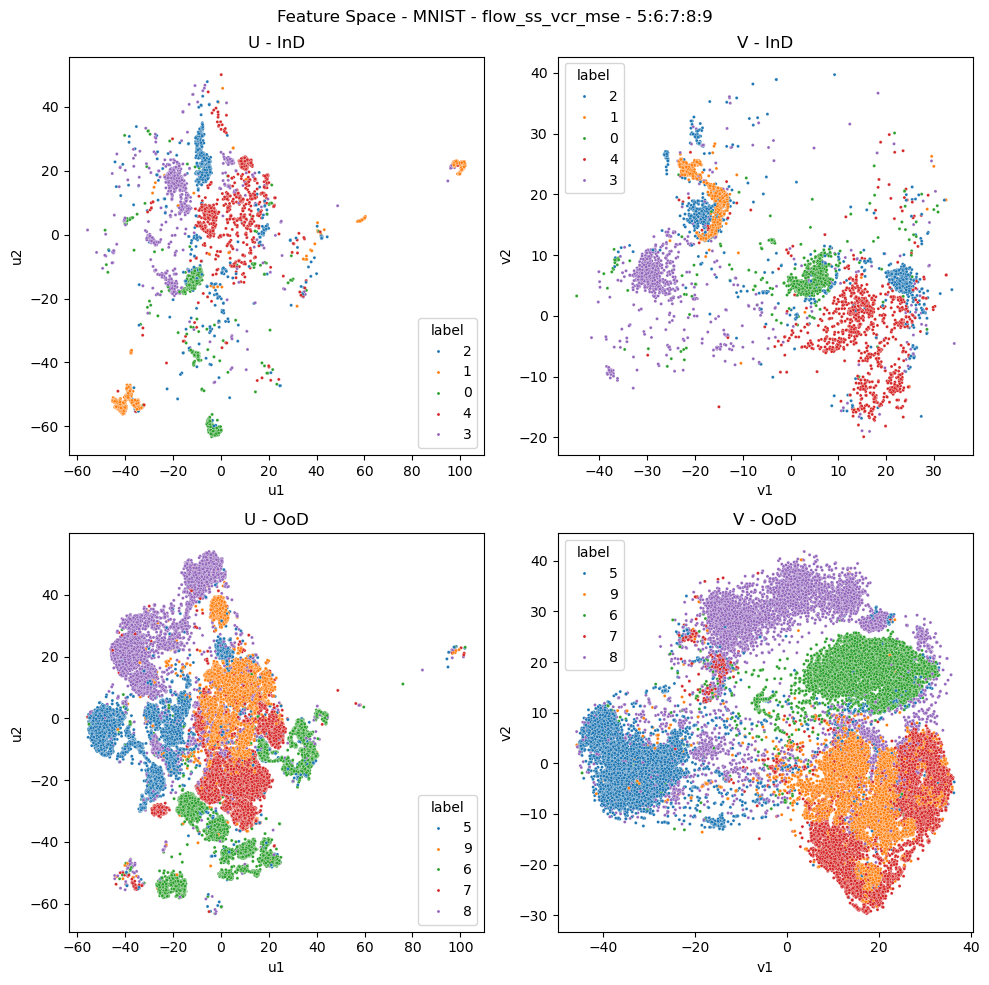

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:00<00:02,  1.07it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:01<00:01,  1.06it/s]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:02<00:00,  1.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.08s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it]

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:02<00:06,  2.22s/it]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:04<00:04,  2.24s/it]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:06<00:02,  2.28s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.37s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.33s/it]

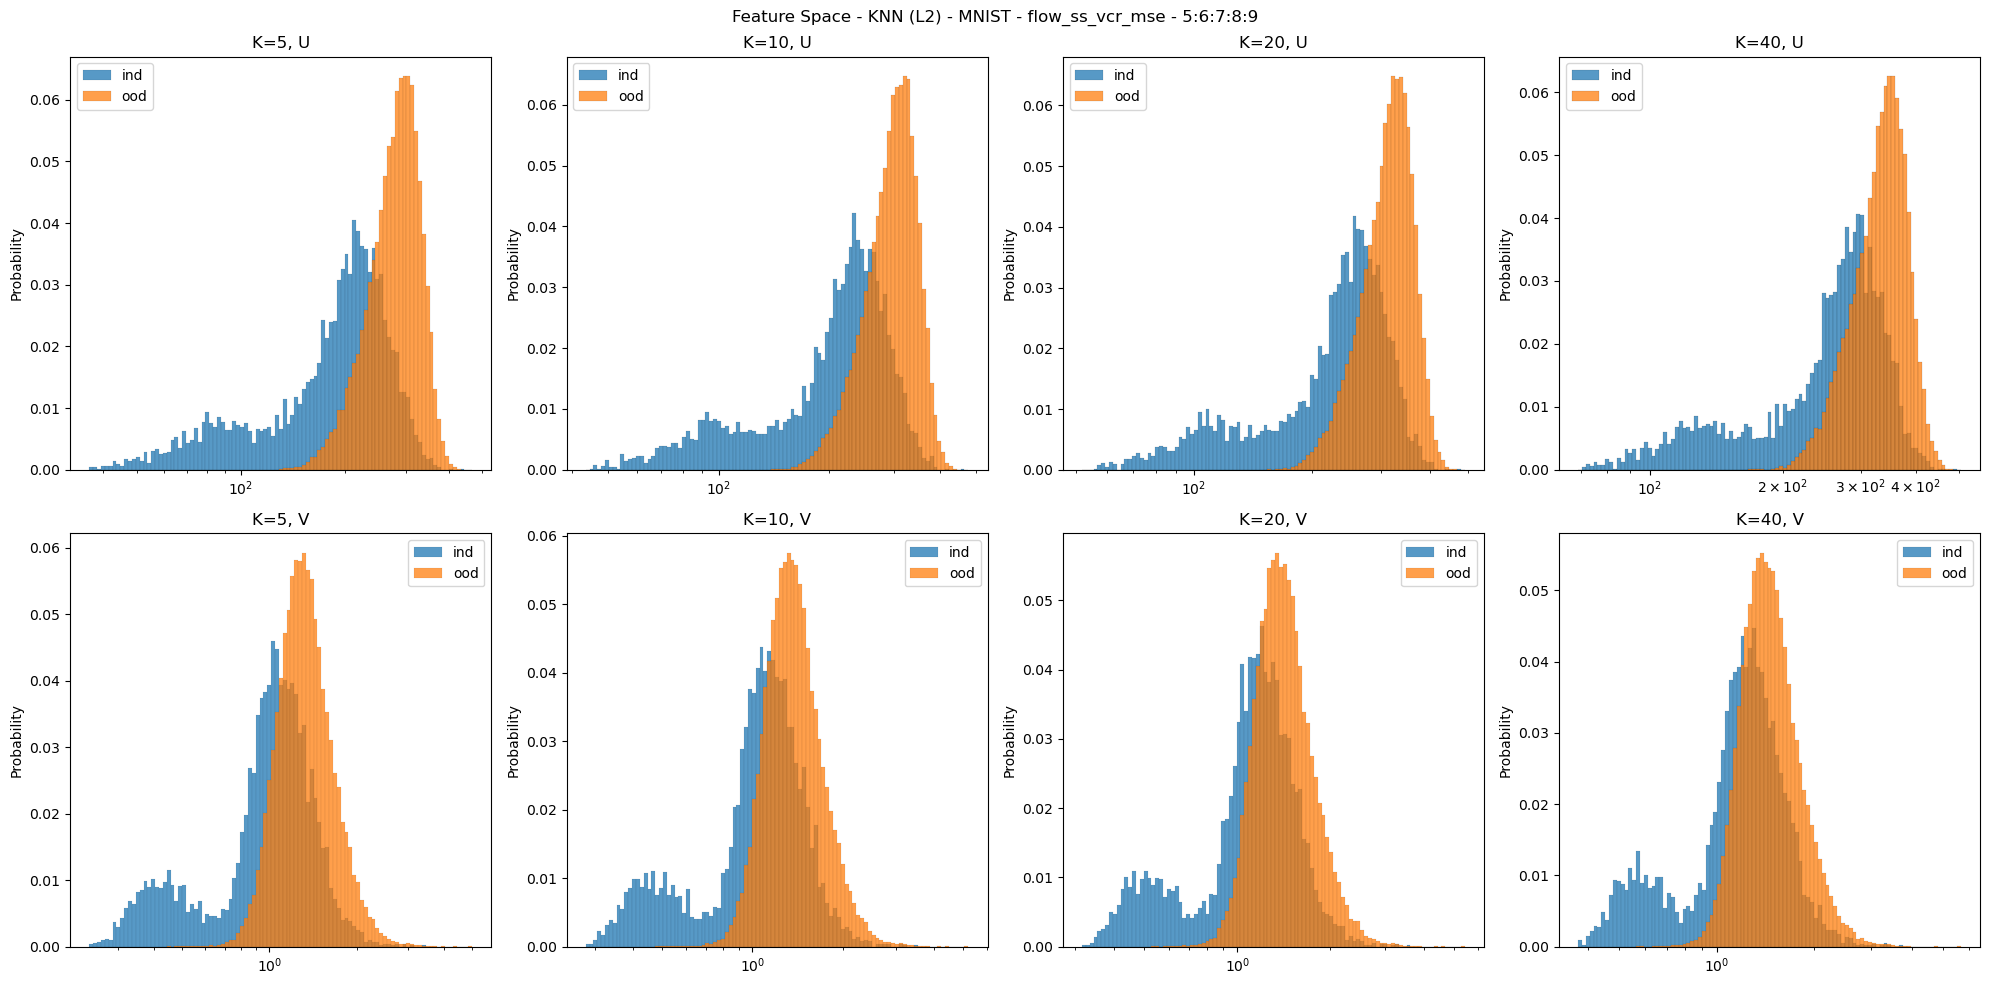

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:00<00:02,  1.10it/s]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:01<00:01,  1.07it/s]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:02<00:00,  1.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.09s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.04s/it]

  0%|                                                                                                           | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████▊                                                                          | 1/4 [00:02<00:06,  2.17s/it]

 50%|█████████████████████████████████████████████████▌                                                 | 2/4 [00:04<00:04,  2.19s/it]

 75%|██████████████████████████████████████████████████████████████████████████▎                        | 3/4 [00:06<00:02,  2.34s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.39s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.34s/it]

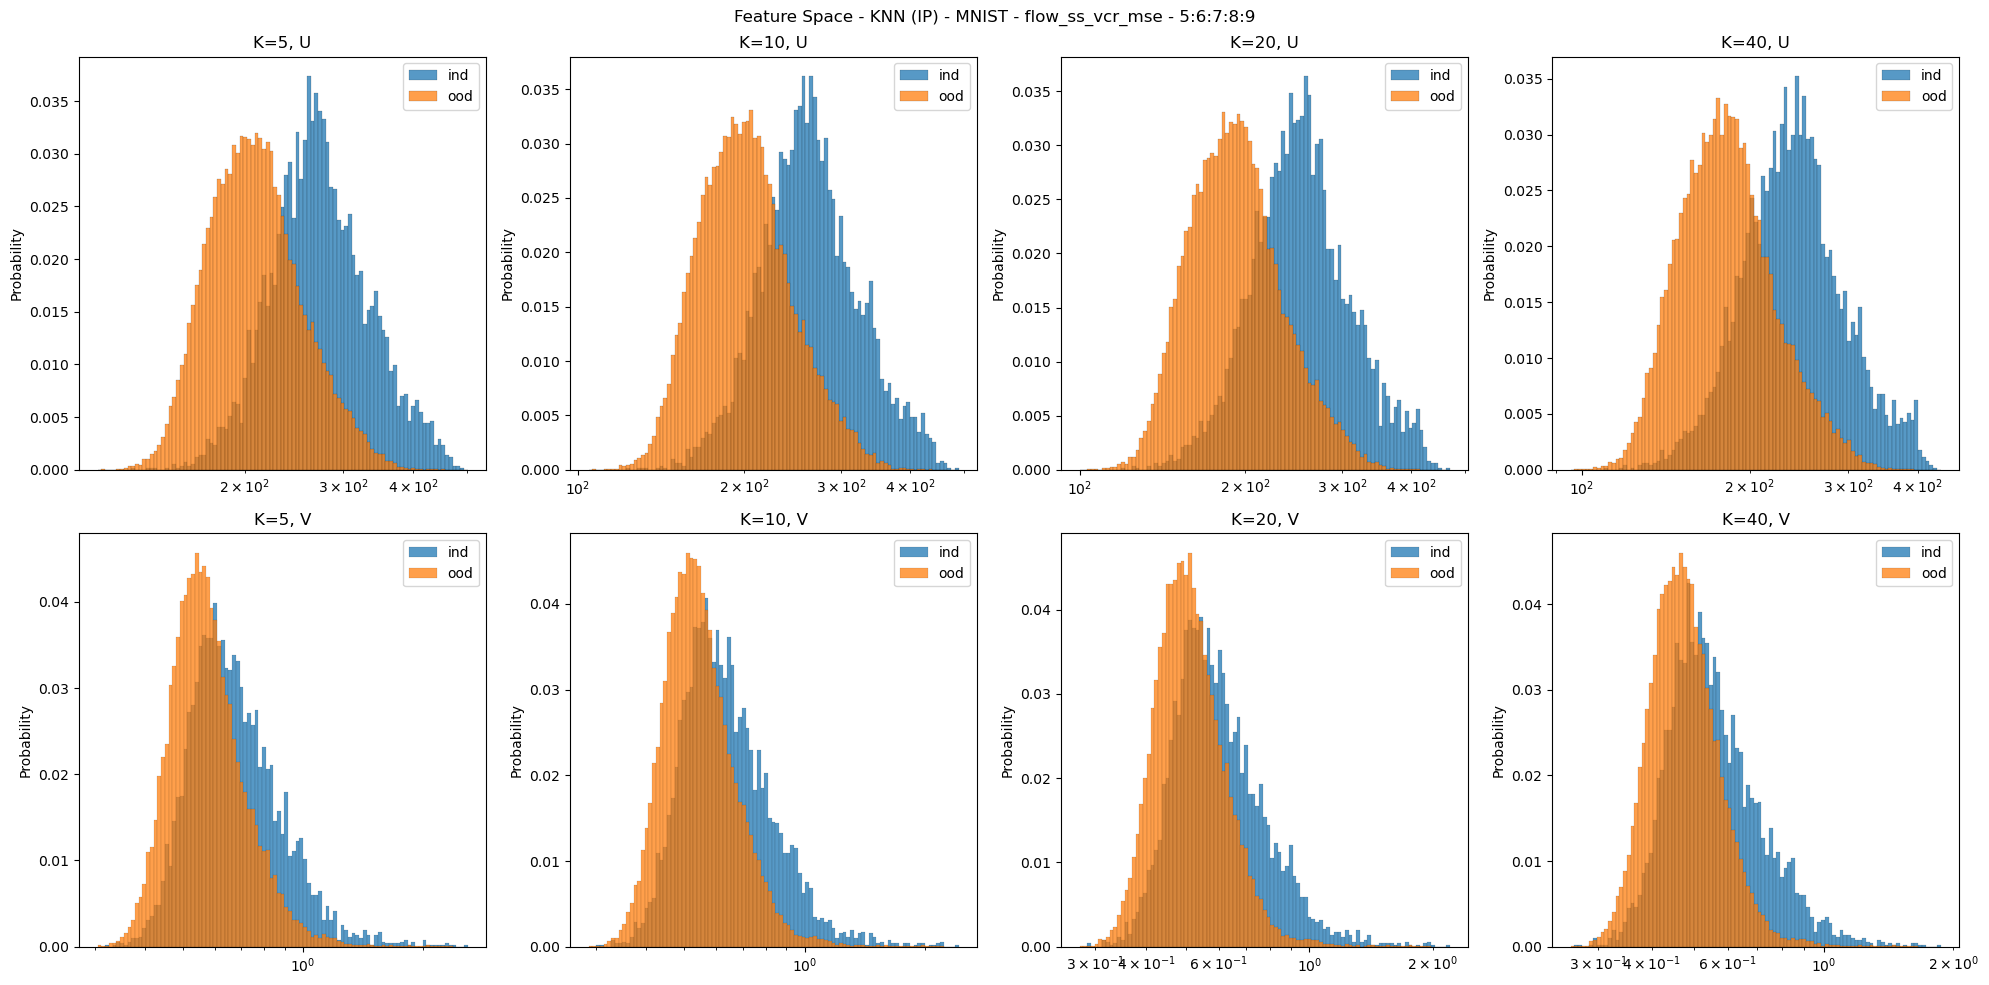

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

18.974464 1.6750635 1.0916301 0.16049697
18.954039 1.6441214 1.0941634 0.16495961
19.015255 1.7016392 1.085783 0.16013552
18.475555 1.3167962 1.14781 0.14863479
33.794605 2.514008 24.835228 0.7264701


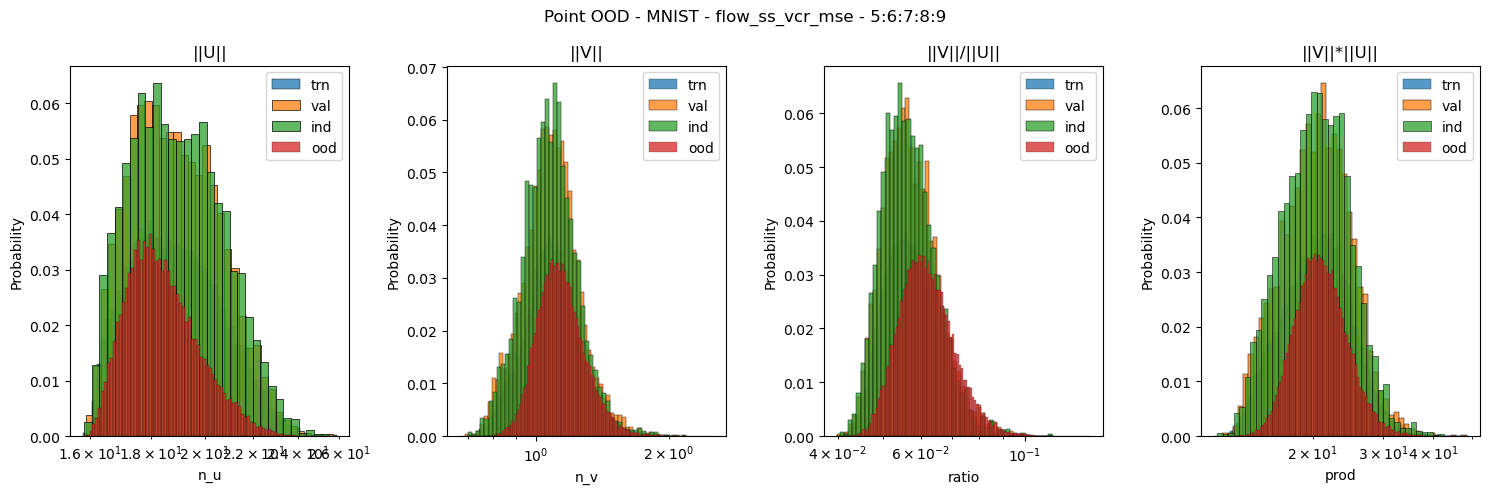

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


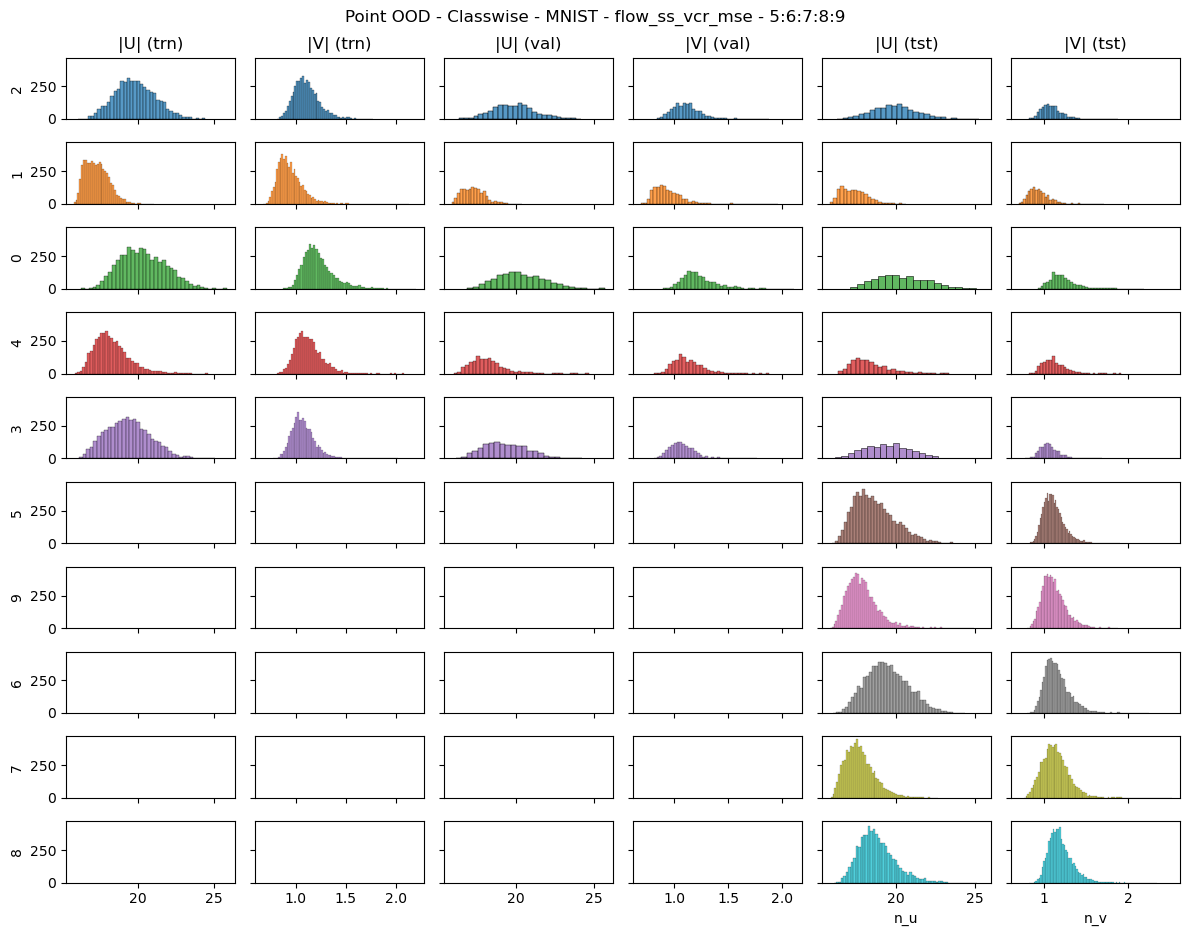

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

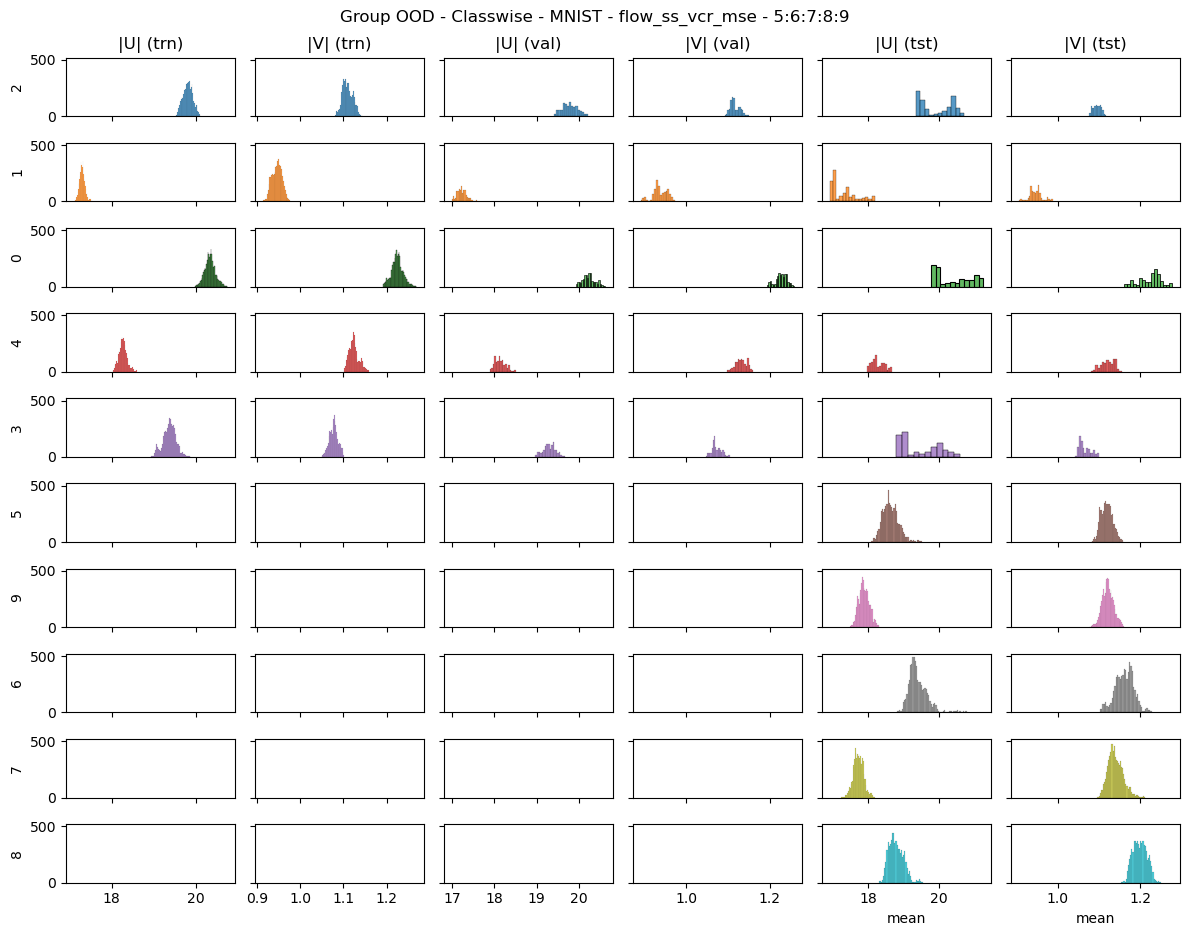

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()